In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl,np,pd,sklearn,tf,keras:
    print(module.__name__,module.__version__)

tf.test.is_gpu_available()

2.0.0
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.1
pandas 0.25.3
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


False

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
x_valid,x_train = x_train_all[:5000],x_train_all[5000:] # 前5000当验证集，后面55000当训练集
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 对数据进行归一化处理 ： x = (x-u) / std
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # 使用scaler来做数据归一化
# 因为要进行卷积操作，所以要把shape变为[28,28,1]，最后一个维度是通道数，这里因为是黑白图像，所以只有一个通道维度
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1) 
x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)
x_test_scaled = scaler.fit_transform(
    x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28,1)

print(np.max(x_train_scaled),np.min(x_train_scaled))
print(np.max(x_valid_scaled),np.min(x_valid_scaled))
print(np.max(x_test_scaled),np.min(x_test_scaled))

2.0231433 -0.8105136
2.0143816 -0.80746
2.0234432 -0.81388575


In [4]:
# 定义卷积神经网络
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32,kernel_size=3,
                        padding="same",activation="relu",input_shape=(28,28,1)),
    keras.layers.Conv2D(filters=32,kernel_size=3,
                        padding="same",activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    # 在进过pool_size为2的pooling之后信息数减少一半，后面为防止信息量不足我们需要把后面的通道数翻倍
    keras.layers.Conv2D(filters=64,kernel_size=3,
                        padding="same",activation="relu"),
    keras.layers.Conv2D(filters=64,kernel_size=3,
                        padding="same",activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=128,kernel_size=3,
                        padding="same",activation="relu"),
    keras.layers.Conv2D(filters=128,kernel_size=3,
                        padding="same",activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    # 在接全连接层前需要先将数据打平
    keras.layers.Flatten(),
    
    # 接全连接层
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

# 因为测试的原因，这里只训练了一个epoch
history = model.fit(x_train_scaled,y_train,epochs=1,
                    validation_data=(x_valid_scaled,y_valid),
                    callbacks=callbacks)

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 122s 2ms/sample - loss: 0.7665 - accuracy: 0.7250 - val_loss: 0.4362 - val_accuracy: 0.8474


/Users/zhenwuzhou/environment/tf2_py3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


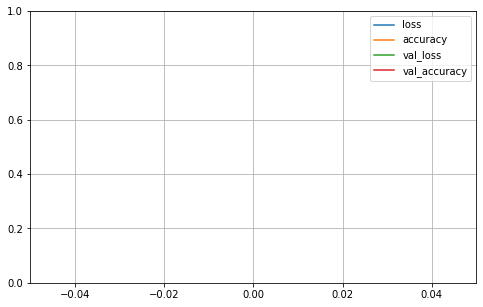

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4785487265348434, 0.8299]